In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import dask
import xarray as xr
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from bbl import *
from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [3]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = dx
delta_t = 60.

In [4]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
std = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t).isel(time=[0])
temp = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t).isel(time=[0])

# Pre-processing

In [5]:
std, grid = add_rotated_coords(std, θ)
temp, _ = add_rotated_coords(temp, θ)

In [6]:
std = add_Nsq(std, Γ)

In [7]:
std = add_hab_coordinates(std, grid, vert_coord='Zl', gridface='C')
std['Nsq_hab'] = hab_interp(std['Nsq'], vert_coord='Zl')

std = add_hab_coordinates(std, grid, vert_coord='Z', gridface='W')
std['UVEL_hab'] = hab_interp(std['UVEL'], gridface='W')

# Find deepest section ("thalweg")

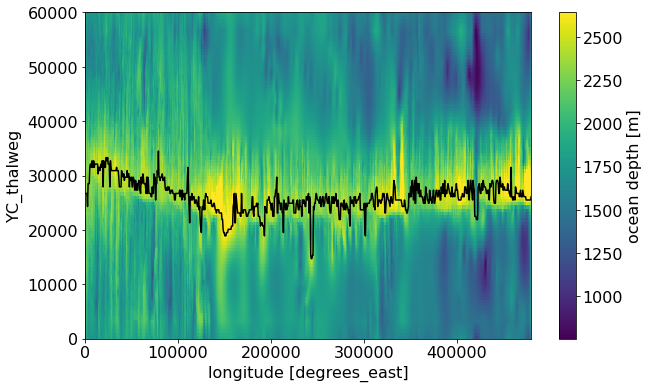

In [8]:
std = add_thalweg(std)
std['Depth'].plot()
std['YC_thalweg'].plot(color="k")

# Sample along thalweg

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


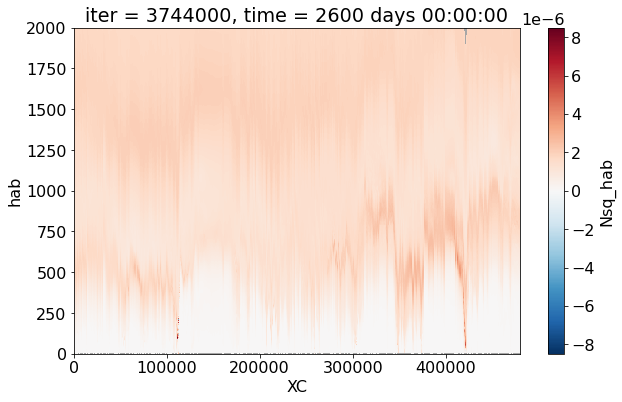

In [9]:
irregular_section(std['Nsq_hab'].isel(time=-1), std['j_thalweg'].values).plot()

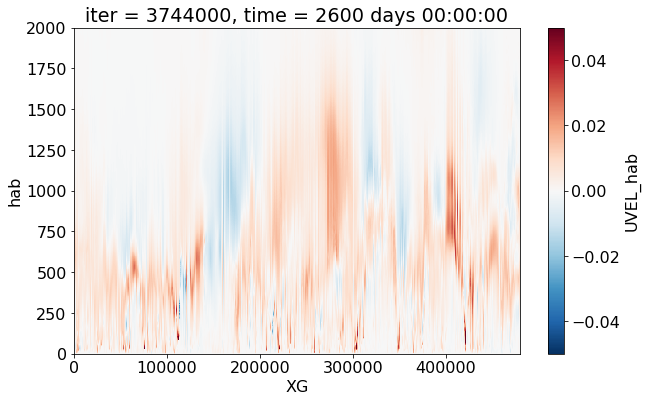

In [10]:
q = irregular_section(std['UVEL_hab'].isel(time=-1), std['j_thalweg'].values, section_dim='XG').plot()
q.set_clim([-0.05,0.05])

# Average within distance of section

In [1]:
test = irregular_section(std['Depth'], std['j_thalweg'].values, width=25)
test.sortby(test.YC).plot(x="XC")

NameError: name 'irregular_section' is not defined

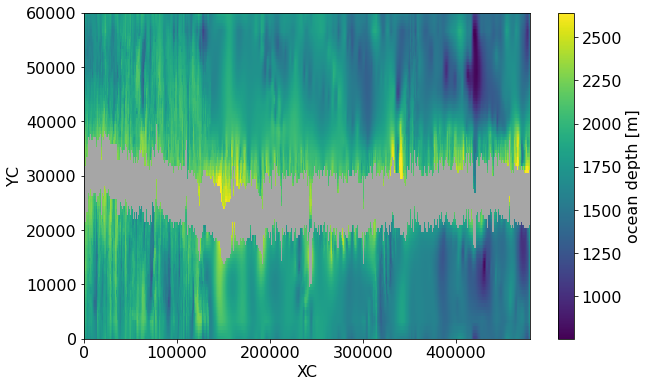

In [12]:
test = irregular_section(std['Depth'], std['j_thalweg'].values, width=8, invert_mask=True)
test.sortby(test.YC).plot(x="XC")

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


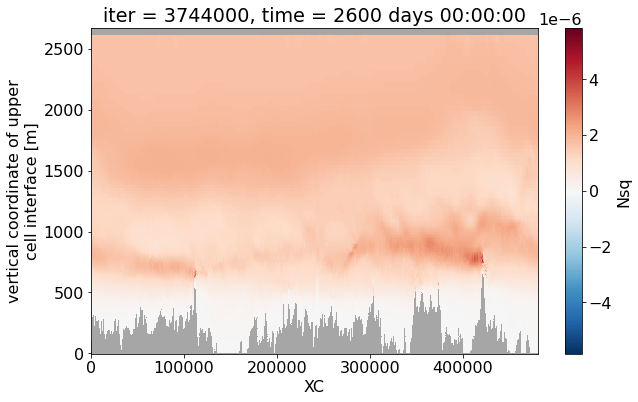

In [13]:
irregular_section(std['Nsq'].isel(time=-1), std['j_thalweg'].values, width=8, return_mean=True).plot()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


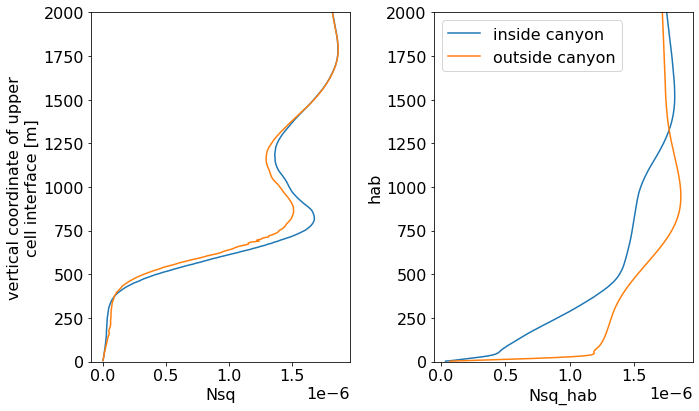

In [14]:
plt.figure()
plt.subplot(1,2,1)
irregular_section(std['Nsq'].isel(time=-1), std['j_thalweg'].values, width=8, return_mean=True).mean(dim='XC', skipna=True).plot(y='Zl', label="inside canyon")
irregular_section(std['Nsq'].isel(time=-1), std['j_thalweg'].values, width=8, return_mean=True, invert_mask=True).mean(dim='XC', skipna=True).plot(y='Zl', label="outside canyon")
plt.ylim([0,2000])
plt.title("")

plt.subplot(1,2,2)
irregular_section(std['Nsq_hab'].isel(time=-1), std['j_thalweg'].values, width=8, return_mean=True).mean(dim='XC', skipna=True).plot(y='hab', label="inside canyon")
irregular_section(std['Nsq_hab'].isel(time=-1), std['j_thalweg'].values, width=8, return_mean=True, invert_mask=True).mean(dim='XC', skipna=True).plot(y='hab', label="outside canyon")
plt.legend()
plt.title("")
plt.ylim([0,2000])
plt.tight_layout()

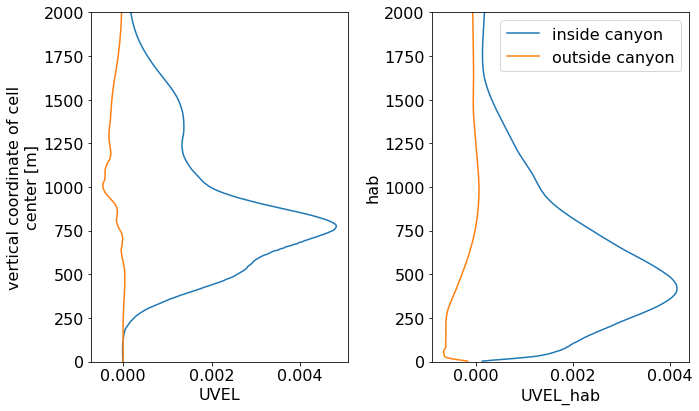

In [15]:
plt.figure()
plt.subplot(1,2,1)
irregular_section(std['UVEL'].isel(time=-1), std['j_thalweg'].values, width=8, return_mean=True, section_dim='XG').mean(dim='XG', skipna=True).plot(y='Z', label="inside canyon")
irregular_section(std['UVEL'].isel(time=-1), std['j_thalweg'].values, width=8, return_mean=True, invert_mask=True, section_dim='XG').mean(dim='XG', skipna=True).plot(y='Z', label="outside canyon")
plt.ylim([0,2000])
plt.title("")

plt.subplot(1,2,2)
irregular_section(std['UVEL_hab'].isel(time=-1), std['j_thalweg'].values, width=8, return_mean=True, section_dim='XG').mean(dim='XG', skipna=True).plot(y='hab', label="inside canyon")
irregular_section(std['UVEL_hab'].isel(time=-1), std['j_thalweg'].values, width=8, return_mean=True, invert_mask=True, section_dim='XG').mean(dim='XG', skipna=True).plot(y='hab', label="outside canyon")
plt.legend()
plt.title("")
plt.ylim([0,2000])
plt.tight_layout()

In [16]:
(1.e-3 / (100**2))**-1 / (4*30*86400.)

0.9645061728395061

# Simulated "observation" profiles

In [17]:
geo = xr.open_dataset(data_dir+"geocoords.nc").drop(["X", "Y"])

In [18]:
lons, lats = [-18.5, -17, -15.], [-21.75, -21.5, -21.3]
samples = sample_locations(geo, lons, lats)

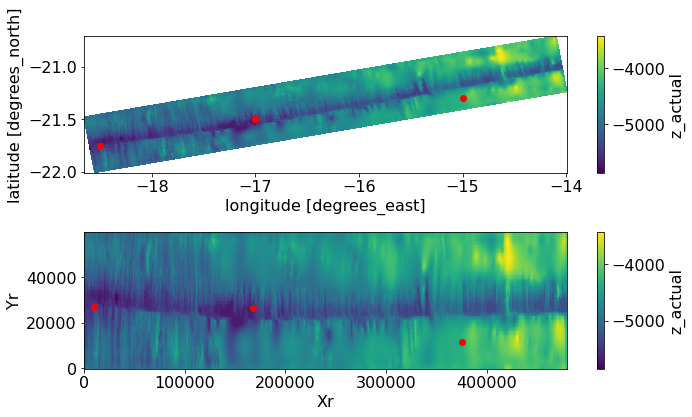

In [19]:
fig, axes = plt.subplots(2, 1)
geo['z_actual'].plot(ax=axes[0], x='lon', y='lat')
axes[0].plot(lons, lats, "ro")
geo['z_actual'].plot(ax=axes[1], x='Xr', y='Yr')
axes[1].plot(geo["Xr"].isel(Xr=samples['i']), geo["Yr"].isel(Yr=samples['j']), "ro")
plt.tight_layout()

# Buoyancy budget

In [20]:
temp = add_temp_budget(temp, grid, Γ, θ)

### Domain-integral budget

In [22]:
check_temp_budget_closes(temp)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


True

In [23]:
Lx, Ly = temp.XC.size*dx, temp.YC.size*dy
cint = k0*Γ*np.cos(θ)*Ly*Lx
cbot = k1*Γ*np.cos(θ)*Ly*Lx

#### Horizontally-averaged buoyancy budget

In [24]:
budget_vars = [
    'total_tendency_TH_truth', 'total_tendency_TH',
    'diff_tendency_TH', 'adv_tendency_TH',
    'conv_adv_flux_anom_TH', 'conv_vert_adv_flux_TH'
]

temp_int_XY = temp[budget_vars].mean(dim='time').sum(dim=['XC','YC'], skipna=True).load()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [25]:
labels = {
    "total_tendency_TH_truth": r"$\frac{1}{\Gamma \sin{\theta}} \int_{0}^{z}\, \frac{\partial{\overline{\Theta}}}{\partial t}\; ds$",
    "total_tendency_TH": r"$-\psi - \frac{1}{\Gamma \sin{\theta}} \langle w \Theta' \rangle + \frac{1}{\Gamma \sin{\theta}}\left[\,\overline{\kappa \Theta_{s}}\,\right]_{0}^{z}$",
    "diff_tendency_TH": r"$\frac{\left[\,\overline{\kappa \Theta_{s}}\,\right]_{0}^{z}}{\Gamma \sin{\theta}}$",
    "conv_adv_flux_anom_TH": r"$-\psi$",
    "conv_vert_adv_flux_TH": r"$-\frac{\langle w \Theta' \rangle}{\Gamma \sin{\theta}}$"
    #"adv_tendency_TH": r"$-\int_{0}^{z}\, \overline{u}\;ds$"
}

for v, var in enumerate(labels.keys()):
    linestyle='-'
    if var=="total_tendency_TH": linestyle="--";
    (temp_check_XY[var]/(Γ*np.sin(θ)*Lx*Ly)).plot(y='Z', label=var, linestyle=linestyle, lw=2.5)
    
plt.legend()

NameError: name 'temp_check_XY' is not defined

#### Vertically-integrated buoyancy budget

In [ ]:
plt.figure(figsize=(12,8))
for v, var in enumerate(labels.keys()):
    linestyle='-'
    if var=="total_tendency_TH": linestyle="--";
    (np.cumsum(temp_check_XY[var][::-1])[::-1]/(Γ*np.sin(θ)*Lx*Ly)).plot(y='Z', label=labels[var], linestyle=linestyle, lw=2.5)
plt.axvline(cint/(Γ*np.sin(θ)*Lx*Ly), linestyle='--', color='g', label=r"$\kappa_{BG} \cot{\theta}$")
plt.tick_params(labeltop=True)
plt.legend()
plt.xlabel(r"temperature tendency cumulative integral [m$^{2}$/s]")
plt.ylabel("slope-normal height [m]")
plt.ylim([0, 2500])
plt.xlim([-0.35, 0.35])
plt.legend()
plt.grid(True)

# Watermass transformations

In [ ]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t).isel(time=[0, 20, -1])

In [ ]:
ds = add_thalweg(ds)

In [ ]:
extend_multiples = [-5, 1]
ds = periodic_extend(ds, ['XC', 'XG'], dx, extend_multiples)
ds, grid = add_rotated_coords(ds, θ)

In [ ]:
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['THETA_BG_U'] = Γ*ds['Zr_U']
ds['THETA_BG_V'] = Γ*ds['Zr_V']
ds['THETA_BG_W'] = Γ*ds['Zr_W']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']
ds['θ'] = ds['θ'].where(ds['hFacC'] != 0)

In [ ]:
dθ = 0.1
θlevs = np.arange(0.-1*dθ, 1.+2*dθ, dθ)

plt.figure(figsize=(12,4))
plt.subplot(1,1,1, facecolor=nancol)
#ds['UVEL'].where(ds['hFacW'] != 0.).isel(time=-1).mean(dim='YC', skipna=True).plot(x='Xr_U', y='Zr_U')
#ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1).mean(dim='YC', skipna=True).plot.contour(x='Xr', y='Zr', levels=θlevs, colors='k', lw=0.75, linestyles='solid')
Usection = irregular_section(
    ds['UVEL'].where(ds['hFacW'] != 0.).isel(time=-1),
    ds['j_thalweg'].values,
    width=4, return_mean=True,
    section_dim='XG'
)
Usection = Usection.assign_coords({'Xr_U':ds['Xr_U'], 'Zr_U':ds['Zr_U']})
Usection.plot(x='Xr_U', y='Zr_U')
θsection = irregular_section(ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1), ds['j_thalweg'].values, width=4, return_mean=True)
θsection = θsection.assign_coords({'Xr':ds['Xr'], 'Zr':ds['Zr']})
θsection.plot.contour(x='Xr', y='Zr', levels=θlevs, colors='k', lw=0.75, linestyles='solid')

plt.tight_layout()
plt.ylim([-400, 1600])

for i in range(*extend_multiples):
    plt.axvline(x=(i+1)*(800*600), alpha=1, linestyle="-", color="y")

In [ ]:
ds = add_temp_budget(ds, grid, Γ, θ)

In [ ]:
dθ = 0.05
θlevs = np.arange(0.-dθ, 1.+dθ, dθ)

mixing = ds['diff_tendency_TH'].fillna(0.)
T = histogram(
    ds['θ'],
    bins=[θlevs],
    weights=mixing,
    dim=('XC', 'YC', 'Z',)
).load()/dθ;

TBBL = histogram(
    ds['θ'],
    bins=[θlevs],
    weights=mixing.where(mixing > 0., 0.),
    dim=('XC', 'YC', 'Z',)
).load()/dθ;

TSML = histogram(
    ds['θ'],
    bins=[θlevs],
    weights=mixing.where(mixing < 0., 0.),
    dim=('XC', 'YC', 'Z',)
).load()/dθ;

In [ ]:
q = ds['diff_tendency_TH'].isel(time=0, YC=50).plot()
q.set_clim(-0.01, 0.01)

In [ ]:
plt.figure(figsize=(6.5, 8))
for i, t in enumerate(T.time.values):
    if i==0:
        T.sel(time=t).plot(y='θ_bin', color="k", label=r"$\mathcal{E}_{net}(b, t)$")
        TBBL.sel(time=t).plot(y='θ_bin', color="r", label=r"$\overline{\mathcal{E}}_{BBL}(b, t)$")
        TSML.sel(time=t).plot(y='θ_bin', color="b", label=r"$\overline{\mathcal{E}}_{SML}(b, t)$")
    else:
        T.sel(time=t).plot(y='θ_bin', color="k")
        TBBL.sel(time=t).plot(y='θ_bin', color="r")
        TSML.sel(time=t).plot(y='θ_bin', color="b")

plt.plot([T.mean(['θ_bin', 'time'])],[1.0], "ko", markersize=10, label=r"$\overline{\mathcal{E}}_{net}$")
plt.plot([TBBL.mean(['θ_bin', 'time'])],[1.0], "ro", markersize=10, label=r"$\overline{\mathcal{E}}_{BBL}$")
plt.plot([TSML.mean(['θ_bin', 'time'])],[1.0], "bo", markersize=10, label=r"$\overline{\mathcal{E}}_{SML}$")

plt.axvline(x=cint/(Γ*np.sin(θ)*Lx), color="grey", lw=3., linestyle = "--", label=r"$\kappa_{BG}\cot{\theta}\, L_{y}$")
plt.axvline(x=cbot/(Γ*np.sin(θ)*Lx), color="grey", lw=3., linestyle = ":", label=r"$\pm \kappa_{Bot}\cot{\theta}\, L_{y}$")
plt.axvline(x=-cbot/(Γ*np.sin(θ)*Lx), color="grey", lw=3., linestyle = ":")

plt.xlabel("Transformation rate [mSv]")
plt.ylabel("Temperature [ºC]")
plt.xticks(np.arange(-100e3, 120e3, 25e3), np.arange(-100, 120, 25));
plt.grid(True)
plt.ylim([-0.4, 1.1])
plt.title("")
plt.legend(loc='lower right', ncol=3, handlelength=1.25, framealpha=1., handletextpad=0.4, columnspacing=0.8)

# Energy budget

# Tracer Moments